## ***Visión por Computadora - 2024***

Stefano Aragoni, Carol Arévalo, José González, Luis Santos

-----------

### *Proyecto 01 - Problema 1*

Deberá implementar algoritmos de binarización que logren reconocer la estructura arterial principal en las imágenes originales. Usted puede elegir cualquier algoritmos de binarización (global o local) de su interés. Pueden ser algoritmos vistos en clase, o puede intentar implementar cualquier otros algoritmo. En cualquier caso, asegúrese de indicar las referencias y fuentes investigadas.

Su algoritmo debe recibir como input la imagen a binarizar, y los parámetros específicos que su método requiera. Como salida, el algoritmo debe devolver una imagen binaria, del mismo tamaño de la imagen input, con la estructura arterial resultante.

-----------

#### *Importar librerías*

Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [2123]:
import os

import matplotlib.pyplot as plt
import numpy as np

import cv2
from scipy import ndimage
from PIL import Image

from skimage import io, color, filters, feature, morphology, exposure, util
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.util import invert
from skimage.filters import threshold_otsu, gaussian, threshold_local
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, disk, remove_small_objects

---------

#### *Cargar imágenes*

Luego, se procede a cargar las imágenes que se utilizarán para el desarrollo del problema.

- Para llevar a cabo este proceso, se definió una función llamada `load_images`. Esta recibe como parámetro el nombre de la imagen a cargar y retorna la imagen en escala de grises.

In [2124]:
def load_image(name_of_image):

    # Definir el directorio de la base de datos
    directory = "./database"

    # Importar imagen en escala de grises
    image = cv2.imread(os.path.join(directory, name_of_image), cv2.IMREAD_GRAYSCALE)

    #Retornar imagen
    return image

- Posteriormente, se definió un ciclo `for` para cargar las 40 imágenes que se utilizarán para el desarrollo del problema.

In [2125]:
# Array para almacenar las imagenes originales y groundtruth
original_images = []
groundtruth_images = []
processed_images = []

# Cargar imagenes
for i in range(1, 21):
    
    original = f"{i}.pgm"
    groundtruth = f"{i}_gt.pgm"

    # Leer imágenes con función load_image y almacenarlas en el array
    original_images.append(load_image(original))
    groundtruth_images.append(load_image(groundtruth))

- Finalmente, se programó una función para mostrar las imágenes cargadas.

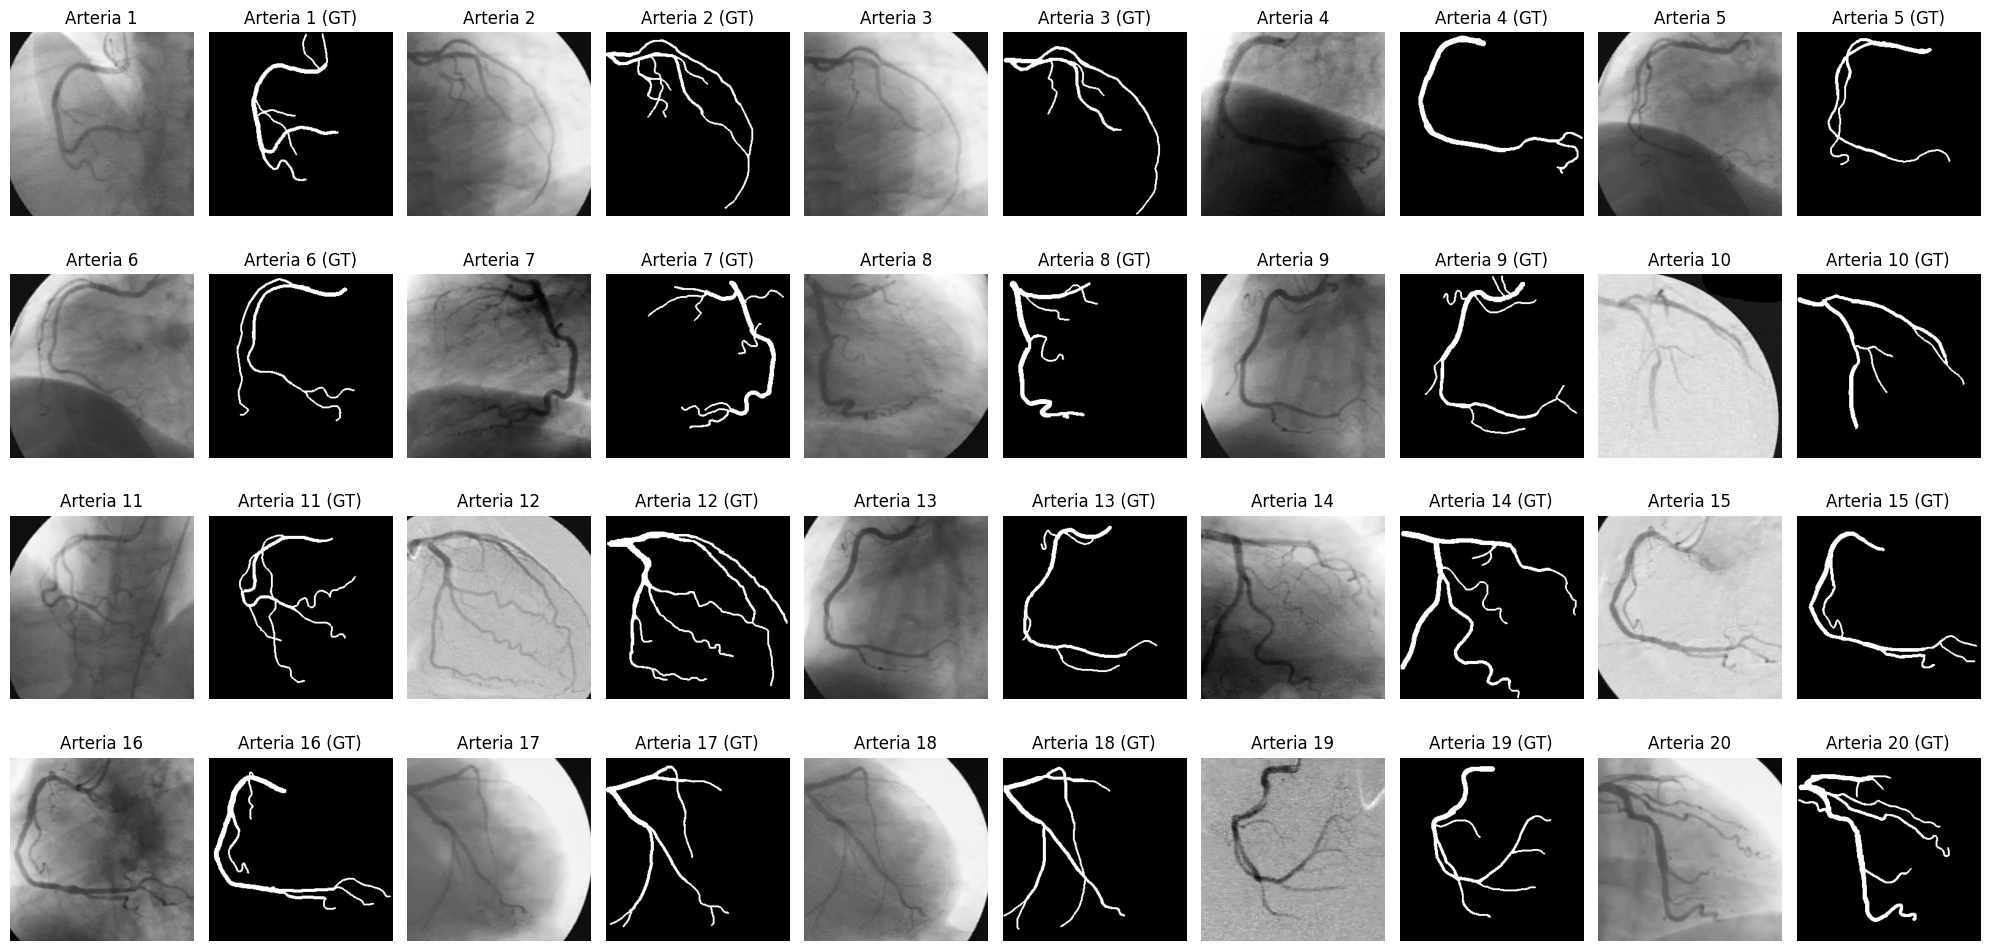

In [2126]:
# Crear una cuadrícula de subfiguras
num_rows = 4
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes y mostrarlas en la cuadrícula
for i in range(0, 20):
    original_img = original_images[i]
    groundtruth_img = groundtruth_images[i]

    # Mostrar imagen original
    axes[index // num_cols, index % num_cols].imshow(original_img, cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1}')

    # Mostrar imagen groundtruth
    axes[(index + 1) // num_cols, (index + 1) % num_cols].imshow(groundtruth_img, cmap='gray')
    axes[(index + 1) // num_cols, (index + 1) % num_cols].axis('off')
    axes[(index + 1) // num_cols, (index + 1) % num_cols].set_title(f'Arteria {i + 1} (GT)')

    # Aumentar el contador de subfiguras
    index += 2

# Ajustar el espacio entre las subfiguras
plt.tight_layout()

plt.show()


*Como se puede observar, hay varias imágenes originales en las que se ve el borde del microscopio (contornos negros en las esquinas). Asimismo, hay varias imágenes con manchas y sombras que pueden afectar el proceso de binarización. Como resultado, será necesario pre-procesar las imágenes.*

---------

#### *Pre-Procesamiento de Imágenes*

Posteriormente, se procede eliminar artefactos y ruido de las imágenes. 

- Como primer punto, se creó una función para eliminar los bordes negros causados por el microscopio. Esto tiene como objetivo eliminar las secciones oscuras de la imagen que no representan arterias.

In [2127]:
def replace_black(imagen):
    
    # Se identifica las partes negras de la imagen (tubo del microscopio)
    _, thresh = cv2.threshold(imagen, 30, 255, cv2.THRESH_BINARY)

    # Invertir thresh
    thresh = cv2.bitwise_not(thresh)

    # Agrandar las áreas blancas para difuminar los bordes
    kernel = np.ones((10, 10), np.uint8)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    # Aplicar el proceso de "inpainting" para rellenar las áreas negras
    imagen = cv2.inpaint(imagen, thresh, inpaintRadius=50, flags=cv2.INPAINT_TELEA)

    return imagen

- Luego, se creó otra función que tiene como objetivo realizar el proceso de *Histogram Equalization*. Además, en esta función también se aplica un filtro de medianas para suavizar la imágen y eliminar ruido.

In [2128]:
def filters(imagen):
    
    # Histogram Equalization CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(35,35))
    clahe_img = clahe.apply(imagen)

    # Aplicar filtro de la medianas
    imagen = cv2.medianBlur(clahe_img, 5)

    return imagen

- Con eso listo, se definió un ciclo `for` para aplicar los cambios a las imágenes originales.

In [2129]:
for i in range(0, 20):

    original_img = original_images[i].copy()

    # ---------------------------- Procesar imagen ----------------------------

    # Remover las partes negras de la imagen
    without_black = replace_black(original_img)

    # Aplicar filtros
    filtered_img = filters(without_black)

    # Almacenar cambios en el array de imágenes procesadas
    processed_images.append(filtered_img)


- Finalmente, se graficaron las imágenes para demostrar el resultado de las operaciones realizadas.

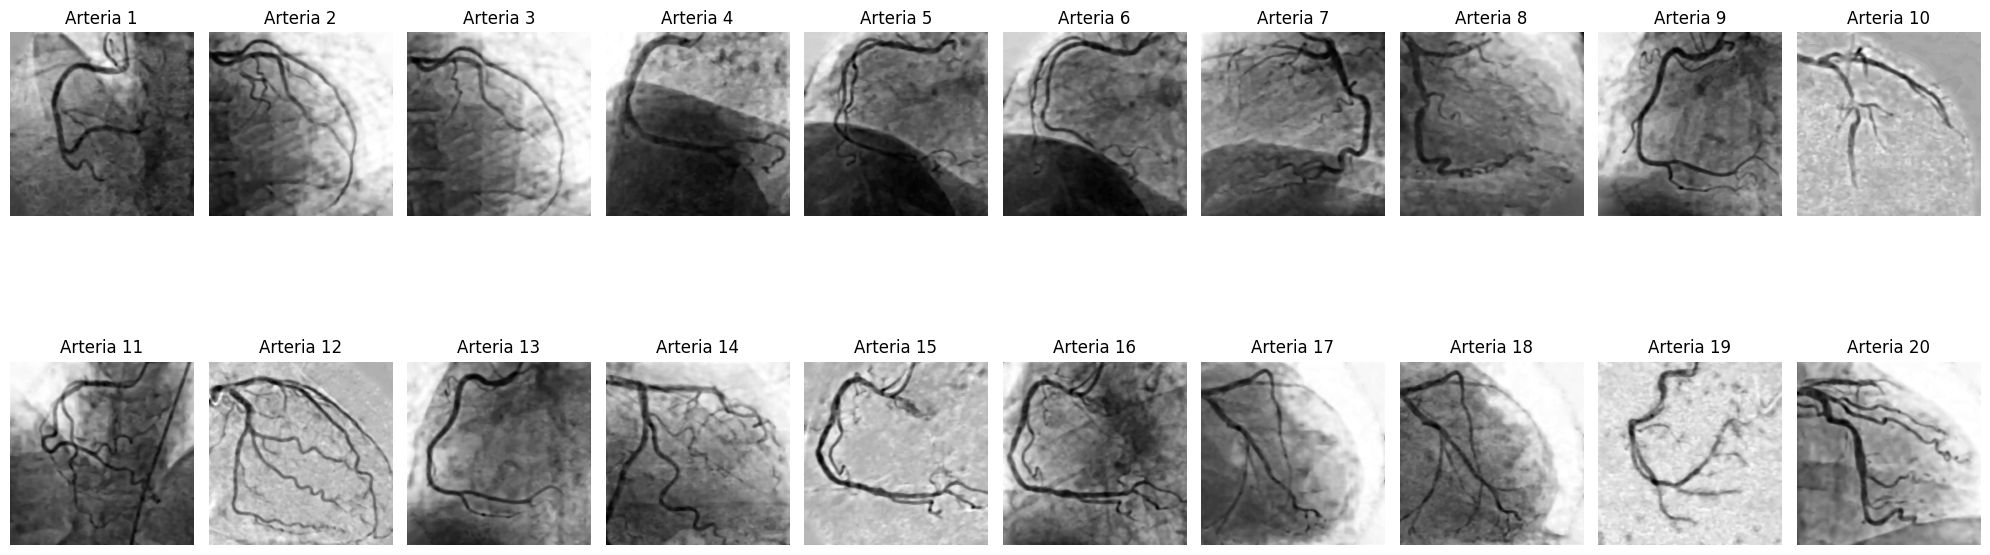

In [2130]:
# Crear una cuadrícula de subfiguras
num_rows = 2
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))

# Iterar sobre las imágenes y mostrarlas en la cuadrícula
for i in range(0, 20):
    processed_img = processed_images[i]

    # Mostrar imagen original
    axes[i // num_cols, i % num_cols].imshow(processed_img, cmap='gray')
    axes[i // num_cols, i % num_cols].axis('off')
    axes[i // num_cols, i % num_cols].set_title(f'Arteria {i + 1}')

# Ajustar el espacio entre las subfiguras
plt.tight_layout()

plt.show()


Como se puede observar, esto permitió poder eliminar los bordes negros del microscópio. Asimismo, se logró oscurecer las arterias para que el proceso de binarización sea más sencillo. 

---------

#### *Binarización de Imágenes*

Luego de haber pre-procesado las imágenes, se puede continuar con el proceso de binarización. 

In [2131]:
def binarize_image(imagen):

    # ---------------------------- BINARIZACIÓN ----------------------------

    # Definir el tamaño de la ventana para la umbralización local de Otsu
    tamaño_ventana = 101

    # Aplicar umbralización local de Otsu
    umbral_local = threshold_local(
        image=imagen,
        block_size=tamaño_ventana,
        method='gaussian',
        param=2.4,
        offset=2.5,
        mode='reflect',
        cval=0
    )

    # Aplicar el umbral local a la imagen para obtener una imagen binaria
    imagen = imagen <= umbral_local

    # Remove small objects
    imagen = remove_small_objects(imagen, connectivity=2, min_size=300)

    # Convertir la imagen binaria a valores de píxeles 0 y 255
    imagen = np.uint8(imagen) * 255

    return imagen

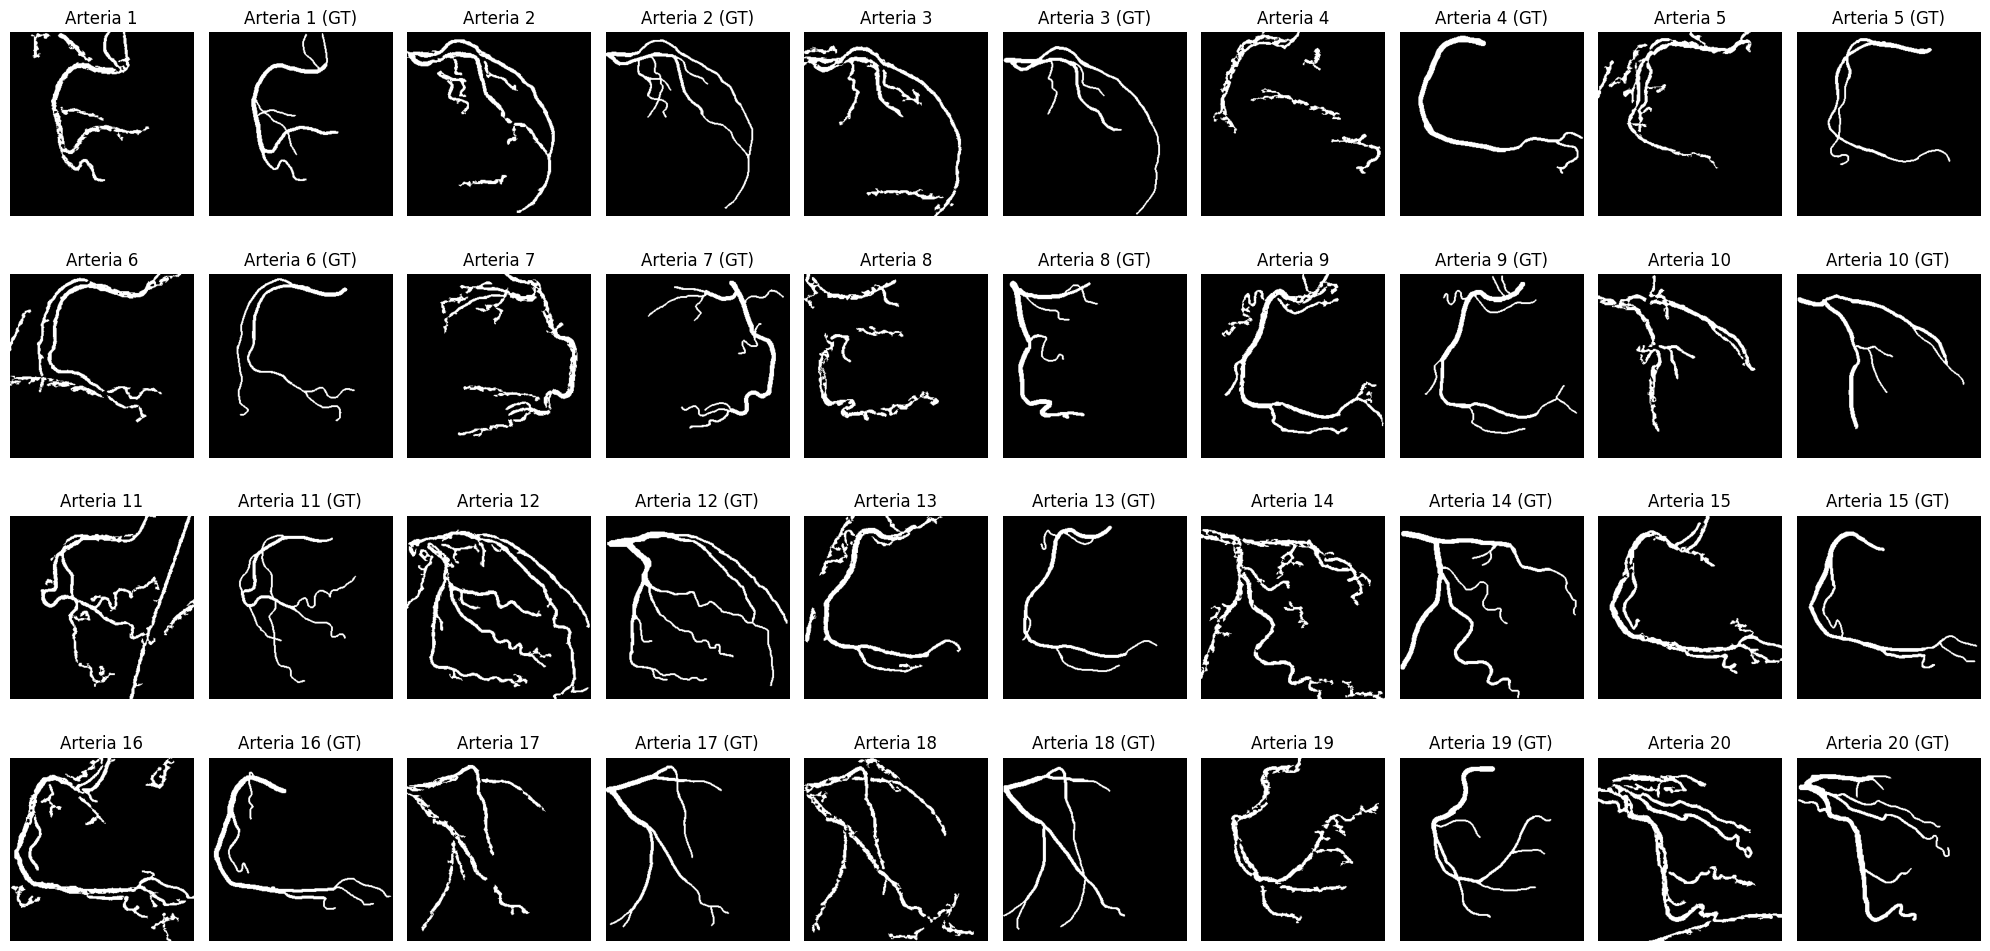

In [2132]:
# Array para almacenar las imágenes binarizadas con umbralización local de Otsu
binarized1_images = []

# Binarizar imágenes con umbralización local de Otsu
for i in range(0, 20):
    
    # Binarizar imagen
    binarized_img = binarize_image(processed_images[i])

    # Almacenar imagen binarizada en el array
    binarized1_images.append(binarized_img)

# Se grafican las imágenes
plot_images(binarized1_images, groundtruth_images)